# GPT-2 Transformer from scratch
Heavily based on: https://arena-chapter1-transformer-interp.streamlit.app/[1.1]_Transformer_from_Scratch


Other resource: https://jalammar.github.io/illustrated-transformer/

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/headers/header-11.png" width="350">

## Setup code

In [1]:
import math
from collections import defaultdict
from dataclasses import dataclass
from typing import Callable

import datasets
import einops
import numpy as np
import torch as t
import torch.nn as nn
from torch import Tensor
from jaxtyping import Float, Int
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from transformers.models.gpt2.tokenization_gpt2_fast import GPT2TokenizerFast
import torch

device = t.device(
    "mps"
    if t.backends.mps.is_available()
    else "cuda"
    if t.cuda.is_available()
    else "cpu"
)


In [ ]:
def gelu_new(
    input: Float[torch.Tensor, "batch pos d_mlp"], # ten string to zapisanie macierzy w sposób do użycia operacji einsum mnożenia mzacierzy
) -> Float[torch.Tensor, "batch pos d_mlp"]:
    # Implementation of GeLU used by GPT2 - subtly different from PyTorch's
    return (
        0.5
        * input
        * (
            1.0
            + torch.tanh(
                np.sqrt(2.0 / np.pi) * (input + 0.044715 * torch.pow(input, 3.0))
            )
        )
    )


# 1️⃣ Understanding Inputs & Outputs of a Transformer

> ##### Learning Objectives
>
> - Understand what a transformer is used for
> - Understand causal attention, and what a transformer's output represents—algebra operations on tensors
> - Learn what tokenization is, and how models do it
> - Understand what logits are, and how to use them to derive a probability distribution over the vocabulary

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/transformer-overview-new.png" width="900">

## Tokens - Transformer Inputs

### Byte-Pair encodings


We begin with the 256 ASCII characters as our tokens, and then find the most common pair of tokens, and merge that into a new token. Note that we do have a space character as one of our 256 tokens, and merges using space are very common.


In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer

reference_gpt2 = AutoModelForCausalLM.from_pretrained(
    "gpt2",
    torch_dtype=torch.float16,
)
tokenizer = AutoTokenizer.from_pretrained("gpt2")

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

C:\Users\Piotr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Piotr\.cache\huggingface\hub\models--gpt2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but th

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [4]:
sorted_vocab = sorted(list(tokenizer.vocab.items()), key=lambda n: n[1])

print(sorted_vocab[:20])

[('!', 0), ('"', 1), ('#', 2), ('$', 3), ('%', 4), ('&', 5), ("'", 6), ('(', 7), (')', 8), ('*', 9), ('+', 10), (',', 11), ('-', 12), ('.', 13), ('/', 14), ('0', 15), ('1', 16), ('2', 17), ('3', 18), ('4', 19)]




### Some tokenization annoyances

There are a few funky and frustrating things about tokenization, which causes it to behave differently than you might expect. For instance:

#### Whether a word begins with a capital or space matters!
#### Arithmetic is a mess.

Length is inconsistent, common numbers bundle together.

In [5]:
print(tokenizer.tokenize("Ralph"))
print(tokenizer.tokenize(" Ralph"))

['R', 'alph']
['ĠRalph']


> ### Key Takeaways
>
> * We learn a dictionary of vocab of tokens (sub-words).
> * We (approx) losslessly convert language to integers via tokenizing it.
> * We convert integers to vectors via a lookup table.
> * Note: input to the transformer is a sequence of *tokens* (ie integers), not vectors

## Text generation

Now that we understand the basic ideas here, let's go through the entire process of text generation, from our original string to a new token which we can append to our string and plug back into the model.

#### **Step 1:** Convert text to tokens

The sequence gets tokenized, so it has shape `[batch, seq_len]`. Here, the batch dimension is just one (because we only have one sequence).

In [6]:
reference_text = "I am great language model!"
tokens = tokenizer(
    reference_text, return_tensors="pt", add_special_tokens=True
).input_ids.to(device)
print(tokens)
print(tokens.shape)
print(tokenizer.decode(tokens[0]))

tensor([[  40,  716, 1049, 3303, 2746,    0]], device='cuda:0')
torch.Size([1, 6])
I am great language model!


#### **Step 2:** Map tokens to logits


From our input of shape `[batch, seq_len]`, we get output of shape `[batch, seq_len, vocab_size]`. The `[i, j, :]`-th element of our output is a vector of logits representing our prediction for the `j+1`-th token in the `i`-th sequence.

In [7]:
reference_gpt2.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [8]:
with torch.no_grad():
    outputs = reference_gpt2(input_ids=tokens)

In [9]:
logits = outputs.logits
logits.shape

torch.Size([1, 6, 50257])

#### **Step 3:** Convert the logits to a distribution with a softmax

This doesn't change the shape, it is still `[batch, seq_len, vocab_size]`.

In [10]:
probs = logits.softmax(dim=-1)
print(probs.shape)

torch.Size([1, 6, 50257])


#### **Step 4:** Map distribution to a token

In [11]:
next_token = logits[0, -1].argmax(dim=-1)

In [12]:
tokenizer.decode(next_token)

' I'

### **Step 5:** Add this to the end of the input, re-run

There are more efficient ways to do this (e.g. where we cache some of the values each time we run our input, so we don't have to do as much calculation each time we generate a new value), but this doesn't matter conceptually right now.

In [13]:
print(f"Sequence so far: {tokenizer.decode(tokens[0])}")
next_char = tokenizer.decode(next_token)
for i in range(10):
    print(f"{tokens.shape[-1] + 1}th char = {next_char!r}")
    # Define new input sequence, by appending the previously generated token
    tokens = t.cat([tokens, next_token[None, None]], dim=-1)
    # Pass our new sequence through the model, to get new output
    logits = reference_gpt2(tokens).logits
    # Get the predicted token at the end of our sequence
    next_token = logits[0, -1].argmax(dim=-1)
    # Decode and print the result
    next_char = tokenizer.decode(next_token)

Sequence so far: I am great language model!
7th char = ' I'
8th char = ' am'
9th char = ' a'
10th char = ' great'
11th char = ' teacher'
12th char = '!'
13th char = ' I'
14th char = ' am'
15th char = ' a'
16th char = ' great'


> ## Key takeaways
> 
> * Transformer takes in language, predicts next token (for *each* token in a causal way)
> * We convert language to a sequence of integers with a tokenizer.
> * We convert integers to vectors with a lookup table.
> * Output is a vector of logits (one for each input token), we convert to a probability distn with a softmax, and can then convert this to a token (eg taking the largest logit, or sampling).
> * We append this to the input + run again to generate more text (Jargon: *autoregressive*)
> * Meta level point: Transformers are sequence operation models, they take in a sequence, do processing in parallel at each position, and use attention to move information between positions!

# 2️⃣ Clean Transformer Implementation

> ##### Learning Objectives
>
> * Understand that a transformer is composed of attention heads and MLPs, with each one performing operations on the residual stream
> * Understand that the attention heads in a single layer operate independently, and that they have the role of calculating attention patterns (which determine where information is moved to & from in the residual stream)
> * Learn about & implement the following transformer modules:
>     * LayerNorm (transforming the input to have zero mean and unit variance)
>     * Positional embedding (a lookup table from position indices to residual stream vectors)
>     * Attention (the method of computing attention patterns for residual stream vectors)
>     * MLP (the collection of linear and nonlinear transformations which operate on each residual stream vector in the same way)
>     * Embedding (a lookup table from tokens to residual stream vectors)
>     * Unembedding (a matrix for converting residual stream vectors into a distribution over tokens)

## High-Level architecture

<img src="https://raw.githubusercontent.com/chloeli-15/ARENA_img/main/img/transformer-new2.png" width="950">

### Tokenization & Embedding

The input tokens $t$ are integers. We get them from taking a sequence, and tokenizing it (like we saw in the previous section).

The token embedding is a lookup table mapping tokens to vectors, which is implemented as a matrix $W_E$. The matrix consists of a stack of token embedding vectors (one for each token).

### Residual stream

The residual stream is the sum of all previous outputs of layers of the model, and is the input to each new layer. It has shape `[batch, seq_len, d_model]` (where `d_model` is the length of a single embedding vector).

The initial value of the residual stream is denoted $x_0$ in the diagram, and $x_i$ are later values of the residual stream (after more attention and MLP layers have been applied to the residual stream).

The residual stream is *really* fundamental. It's the central object of the transformer. It's how model remembers things, moves information between layers for composition, and it's the medium used to store the information that attention moves between positions.


### Transformer blocks

Then we have a series of `n_layers` **transformer blocks** (also sometimes called **residual blocks**).

Note - a block contains an attention layer *and* an MLP layer, but we say a transformer has $k$ layers if it has $k$ blocks (i.e. $2k$ total layers).

<img src="https://raw.githubusercontent.com/chloeli-15/ARENA_img/main/img/transformer-block2.png" width="700">

### Attention

First we have attention. This moves information from prior positions in the sequence to the current token.

We do this for *every* token in parallel using the same parameters. The only difference is that we look backwards only (to avoid "cheating"). This means later tokens have more of the sequence that they can look at.

Attention layers are the only bit of a transformer that moves information between positions (i.e. between vectors at different sequence positions in the residual stream).

Attention layers are made up of `n_heads` heads - each with their own parameters, own attention pattern, and own information how to copy things from source to destination. The heads act independently and additively, we just add their outputs together, and back to the stream.

Each head does the following:
* Produces an **attention pattern** for each destination token, a probability distribution of prior source tokens (including the current one) weighting how much information to copy.
* Moves information (via a linear map) in the same way from each source token to each destination token.

<img src="https://raw.githubusercontent.com/chloeli-15/ARENA_img/main/img/transformer-attn-new-v2.png" width="1050">

### MLP

The MLP layers are just a standard neural network, with a singular hidden layer and a nonlinear activation function. The exact activation isn't conceptually important ([GELU](https://paperswithcode.com/method/gelu) seems to perform best).

Our hidden dimension is normally `d_mlp = 4 * d_model`. Exactly why the ratios are what they are isn't super important (people basically cargo-cult what GPT did back in the day!).

Importantly, **the MLP operates on positions in the residual stream independently, and in exactly the same way**. It doesn't move information between positions.


<img src="https://raw.githubusercontent.com/chloeli-15/ARENA_img/main/img/transformer-mlp-new-2.png" width="680">

### Unembedding

Finally, we unembed!

This just consists of applying a linear map $W_U$, going from final residual stream to a vector of logits - this is the output.


#### LayerNorm

* Simple normalization function applied at the start of each layer (i.e. before each MLP, attention layer, and before the unembedding)
* Converts each input vector (independently in parallel for each `(batch, seq)` residual stream vector) to have mean zero and variance 1.
* Then applies an elementwise scaling and translation


## Actual Code!

Model architecture table (this will be helpful for understanding the results you get when running the code block below):

| Parameter   | Value          |
|-------------|----------------|
| batch       | 1              |
| position    | 6             |
| d_model     | 768            |
| n_heads     | 12             |
| n_layers    | 12             |
| d_mlp       | 3072 (= 4 * `d_model`) |
| d_head      | 64 (= `d_model / n_heads`) |

In [14]:
@dataclass
class Config:
    d_model: int = 768
    debug: bool = True
    layer_norm_eps: float = 1e-5
    d_vocab: int = 50257
    init_range: float = 0.02
    n_ctx: int = 1024
    d_head: int = 64
    d_mlp: int = 3072
    n_heads: int = 12
    n_layers: int = 12


cfg = Config()
print(cfg)

Config(d_model=768, debug=True, layer_norm_eps=1e-05, d_vocab=50257, init_range=0.02, n_ctx=1024, d_head=64, d_mlp=3072, n_heads=12, n_layers=12)


### LayerNorm

LayerNorm should do the following:

* Make mean 0
* Normalize to have variance 1
* Scale with learned weights
* Translate with learned bias


In [15]:
class LayerNorm(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.w = nn.Parameter(t.ones(cfg.d_model))
        self.b = nn.Parameter(t.zeros(cfg.d_model))

    def forward(
        self, residual: Float[Tensor, "batch posn d_model"]
    ) -> Float[Tensor, "batch posn d_model"]:
        residual_mean = residual.mean(dim=-1, keepdim=True)
        residual_std = (
            residual.var(dim=-1, keepdim=True, unbiased=False) + self.cfg.layer_norm_eps
        ).sqrt()

        residual = (residual - residual_mean) / residual_std
        return residual * self.w + self.b

### Embedding

The input tokens $t$ are integers. We get them from taking a sequence, and tokenizing it (like we saw in the previous section).

The token embedding is a lookup table mapping tokens to vectors, which is implemented as a matrix $W_E$. The matrix consists of a stack of token embedding vectors (one for each token).

In [16]:
class Embed(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.W_E = nn.Parameter(t.empty((cfg.d_vocab, cfg.d_model)))
        nn.init.normal_(self.W_E, std=self.cfg.init_range)

    def forward(
        self, tokens: Int[Tensor, "batch position"]
    ) -> Float[Tensor, "batch position d_model"]:
        return self.W_E[tokens]

### Positional embedding
Positional embedding can also be thought of as a lookup table, but rather than the indices being our token IDs, the indices are just the numbers `0`, `1`, `2`, ..., `seq_len-1` (i.e. the position indices of the tokens in the sequence).

In [17]:
class PosEmbed(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.W_pos = nn.Parameter(t.empty((cfg.n_ctx, cfg.d_model)))
        nn.init.normal_(self.W_pos, std=self.cfg.init_range)

    def forward(
        self, tokens: Int[Tensor, "batch position"]
    ) -> Float[Tensor, "batch position d_model"]:
        batch, seq_len = tokens.shape
        return einops.repeat(
            self.W_pos[:seq_len], "seq d_model -> batch seq d_model", batch=batch
        )

### Attention


* **Step 1:** Produce an attention pattern - for each destination token, probability distribution over previous tokens (including current token)
    * Linear map from input -> query, key shape `[batch, seq_posn, head_index, d_head]`
    * Dot product every *pair* of queries and keys to get attn_scores `[batch, head_index, query_pos, key_pos]` (query = dest, key = source)
    * **Scale** and mask `attn_scores` to make it lower triangular, i.e. causal
    * Softmax along the `key_pos` dimension, to get a probability distribution for each query (destination) token - this is our attention pattern!
* **Step 2:** Move information from source tokens to destination token using attention pattern (move = apply linear map)
    * Linear map from input -> value `[batch, key_pos, head_index, d_head]`
    * Mix along the `key_pos` with attn pattern to get `z`, which is a weighted average of the value vectors `[batch, query_pos, head_index, d_head]`
    * Map to output, `[batch, position, d_model]` (position = query_pos, we've summed over all heads)

Note - when we say **scale**, we mean dividing by `sqrt(d_head)`. The purpose of this is to avoid vanishing gradients (which is a big problem when we're dealing with a function like softmax - if one of the values is much larger than all the others, the probabilities will be close to 0 or 1, and the gradients will be close to 0).

Below is a much larger, more detailed version of the attention head diagram from earlier. This should give you an idea of the actual tensor operations involved. A few clarifications on this diagram:

* Whenever there is a third dimension shown in the pictures, this refers to the `head_index` dimension. We can see that all operations within the attention layer are done independently for each head.
* The objects in the box are activations; they have a batch dimension (for simplicity, we assume the batch dimension is 1 in the diagram). The objects to the right of the box are our parameters (weights and biases); they have no batch dimension.
* We arrange the keys, queries and values as `(batch, seq_pos, head_idx, d_head)`, because the biases have shape `(head_idx, d_head)`, so this makes it convenient to add the biases (recall the rules of array broadcasting!).

<img src="https://raw.githubusercontent.com/chloeli-15/ARENA_img/main/img/transformer-attn-30.png" width="1400">

In [ ]:
class Attention(nn.Module):
    IGNORE: Float[Tensor, ""]

    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.W_Q = nn.Parameter(t.empty((cfg.n_heads, cfg.d_model, cfg.d_head))) # to są weights
        self.W_K = nn.Parameter(t.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.W_V = nn.Parameter(t.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.W_O = nn.Parameter(t.empty((cfg.n_heads, cfg.d_head, cfg.d_model)))
        self.b_Q = nn.Parameter(t.zeros((cfg.n_heads, cfg.d_head))) # to są biaas
        self.b_K = nn.Parameter(t.zeros((cfg.n_heads, cfg.d_head)))
        self.b_V = nn.Parameter(t.zeros((cfg.n_heads, cfg.d_head)))
        self.b_O = nn.Parameter(t.zeros((cfg.d_model)))
        nn.init.normal_(self.W_Q, std=self.cfg.init_range)
        nn.init.normal_(self.W_K, std=self.cfg.init_range)
        nn.init.normal_(self.W_V, std=self.cfg.init_range)
        nn.init.normal_(self.W_O, std=self.cfg.init_range)
        self.register_buffer(
            "IGNORE", t.tensor(float("-inf"), dtype=t.float32, device=device) # IGNRORE to maskowanie -inf
        )

    def forward(
        self, normalized_resid_pre: Float[Tensor, "batch posn d_model"] # mnożenie przy pomocy einsum jest przydatny, bo nie trzeba się zastanawiać jak resizować macierzy, ani transponować
    ) -> Float[Tensor, "batch posn d_model"]:
        # Calculate query, key and value vectors
        q = (
            einops.einsum(
                normalized_resid_pre,
                self.W_Q,
                "batch posn d_model, nheads d_model d_head -> batch posn nheads d_head", # to jest przetwarzanie macierzy przy pomocy einsum
            )
            + self.b_Q
        )
        k = (
            einops.einsum(
                normalized_resid_pre,
                self.W_K,
                "batch posn d_model, nheads d_model d_head -> batch posn nheads d_head",
            )
            + self.b_K
        )
        v = (
            einops.einsum(
                normalized_resid_pre,
                self.W_V,
                "batch posn d_model, nheads d_model d_head -> batch posn nheads d_head",
            )
            + self.b_V
        )

        # Calculate attention scores, then scale and mask, and apply softmax to get probabilities
        attn_scores = einops.einsum(
            q,
            k,
            "batch posn_Q nheads d_head, batch posn_K nheads d_head -> batch nheads posn_Q posn_K",
        )
        attn_scores_masked = self.apply_causal_mask(attn_scores / self.cfg.d_head**0.5)
        attn_pattern = attn_scores_masked.softmax(-1)

        # Take weighted sum of value vectors, according to attention probabilities
        z = einops.einsum(
            v,
            attn_pattern,
            "batch posn_K nheads d_head, batch nheads posn_Q posn_K -> batch posn_Q nheads d_head",
        )

        # Calculate output (by applying matrix W_O and summing over heads, then adding bias b_O)
        attn_out = (
            einops.einsum(
                z,
                self.W_O,
                "batch posn_Q nheads d_head, nheads d_head d_model -> batch posn_Q d_model",
            )
            + self.b_O
        )

        return attn_out

    def apply_causal_mask(
        self, attn_scores: Float[Tensor, "batch n_heads query_pos key_pos"]
    ) -> Float[Tensor, "batch n_heads query_pos key_pos"]:
        """
        Applies a causal mask to attention scores, and returns masked scores.
        """
        # Define a mask that is True for all positions we want to set probabilities to zero for
        all_ones = t.ones(
            attn_scores.size(-2), attn_scores.size(-1), device=attn_scores.device
        )
        mask = t.triu(all_ones, diagonal=1).bool() # górna macierz trójkątna
        # Apply the mask to attention scores, then return the masked scores
        attn_scores.masked_fill_(mask, self.IGNORE)
        return attn_scores

### MLP
the MLP layer consists of:

* A linear layer, with weight `W_in`, bias `b_in`
* A nonlinear function (we usually use GELU; the function `gelu_new` has been imported for this purpose)
* A linear layer, with weight `W_out`, bias `b_out`

In [19]:
class MLP(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.W_in = nn.Parameter(t.empty((cfg.d_model, cfg.d_mlp)))
        self.W_out = nn.Parameter(t.empty((cfg.d_mlp, cfg.d_model)))
        self.b_in = nn.Parameter(t.zeros((cfg.d_mlp)))
        self.b_out = nn.Parameter(t.zeros((cfg.d_model)))
        nn.init.normal_(self.W_in, std=self.cfg.init_range)
        nn.init.normal_(self.W_out, std=self.cfg.init_range)

    def forward(
        self, normalized_resid_mid: Float[Tensor, "batch posn d_model"]
    ) -> Float[Tensor, "batch posn d_model"]:
        pre = (
            einops.einsum(
                normalized_resid_mid,
                self.W_in,
                "batch position d_model, d_model d_mlp -> batch position d_mlp",
            )
            + self.b_in
        )
        post = gelu_new(pre)
        mlp_out = (
            einops.einsum(
                post,
                self.W_out,
                "batch position d_mlp, d_mlp d_model -> batch position d_model",
            )
            + self.b_out
        )
        return mlp_out

### TransformerBlock


In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.ln1 = LayerNorm(cfg)
        self.attn = Attention(cfg)
        self.ln2 = LayerNorm(cfg)
        self.mlp = MLP(cfg)

    def forward(
        self, resid_pre: Float[Tensor, "batch position d_model"]
    ) -> Float[Tensor, "batch position d_model"]:
        resid_mid = self.attn(self.ln1(resid_pre)) + resid_pre # Skip connection
        resid_post = self.mlp(self.ln2(resid_mid)) + resid_mid
        return resid_post

### Unembed

The unembedding is just a linear layer (with weight `W_U` and bias `b_U`).

In [ ]:
class Unembed(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.W_U = nn.Parameter(t.empty((cfg.d_model, cfg.d_vocab))) # Mapowanie na słownik embedding do słowa
        nn.init.normal_(self.W_U, std=self.cfg.init_range)
        self.b_U = nn.Parameter(t.zeros((cfg.d_vocab), requires_grad=False))

    def forward(
        self, normalized_resid_final: Float[Tensor, "batch position d_model"]
    ) -> Float[Tensor, "batch position d_vocab"]:
        return (
            einops.einsum(
                normalized_resid_final,
                self.W_U,
                "batch posn d_model, d_model d_vocab -> batch posn d_vocab",
            )
            + self.b_U
        )

### DemoTransformer



In [22]:
class DemoTransformer(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.embed = Embed(cfg)
        self.pos_embed = PosEmbed(cfg)
        self.blocks = nn.ModuleList(
            [TransformerBlock(cfg) for _ in range(cfg.n_layers)]
        )
        self.ln_final = LayerNorm(cfg)
        self.unembed = Unembed(cfg)

    def forward(
        self, tokens: Int[Tensor, "batch position"]
    ) -> Float[Tensor, "batch position d_vocab"]:
        residual = self.embed(tokens) + self.pos_embed(tokens)
        for block in self.blocks:
            residual = block(residual)
        logits = self.unembed(self.ln_final(residual))
        return logits

# 3️⃣ Training a Transformer

> ##### Learning Objectives
>
> * Understand how to train a transformer from scratch
> * Write a basic transformer training loop
> * Interpret the transformer's falling cross entropy loss with reference to features of the training data (e.g. bigram frequencies)

## Create Model

In [23]:
tokenizer.add_special_tokens({"pad_token": "<PAD>"})
tokenizer.pad_token_id

50257

In [ ]:
model_cfg = Config( # Trochę mniejszy model, żeby szybciej się trenował
    d_model=256,
    n_heads=4,
    d_head=64,
    d_mlp=1024,
    n_layers=2,
    n_ctx=256,
    d_vocab=tokenizer.vocab_size + 1,  # PAD
)
model = DemoTransformer(model_cfg)

## Training Args


Note, for this optimization we'll be using **weight decay**.

In [ ]:
@dataclass
class TransformerTrainingArgs: # Mały trening
    batch_size = 16
    epochs = 20
    max_steps_per_epoch = 200
    lr = 1e-3
    weight_decay = 1e-2


args = TransformerTrainingArgs()

## Create Data


In [26]:
dataset = datasets.load_dataset("NeelNanda/pile-10k", split="train").remove_columns(
    "meta"
)
print(dataset)
print(dataset[0]["text"][:100])

README.md:   0%|          | 0.00/373 [00:00<?, ?B/s]

C:\Users\Piotr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Piotr\.cache\huggingface\hub\datasets--NeelNanda--pile-10k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


dataset_infos.json:   0%|          | 0.00/921 [00:00<?, ?B/s]

(…)-00000-of-00001-4746b8785c874cc7.parquet:   0%|          | 0.00/33.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset({
    features: ['text'],
    num_rows: 10000
})
It is done, and submitted. You can play “Survival of the Tastiest” on Android, and on the web. Playi


In [27]:
def tokenize_function(examples):
    # First tokenize without BOS token
    tokenized = tokenizer(
        examples["text"],
        truncation=True,
        max_length=model_cfg.n_ctx - 1,  # Leave room for BOS token
        padding="max_length",
        return_tensors="pt",  # Return PyTorch tensors
    )

    # Add BOS token at the beginning of each sequence
    input_ids = tokenized["input_ids"]
    num_sequences = len(input_ids)
    bos_tokens = torch.full((num_sequences, 1), tokenizer.bos_token_id)
    tokenized["input_ids"] = torch.cat([bos_tokens, input_ids], dim=1)

    return tokenized


tokenized_dataset = dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=dataset.column_names,
    desc="Tokenizing dataset",
)
tokenized_dataset.set_format("torch")

tokenized_dataset = tokenized_dataset.rename_column("input_ids", "tokens")
tokenized_dataset


Tokenizing dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset({
    features: ['tokens', 'attention_mask'],
    num_rows: 10000
})

In [28]:
dataset_dict = tokenized_dataset.train_test_split(test_size=1000)


In [29]:
train_loader = DataLoader(
    dataset_dict["train"],
    batch_size=args.batch_size,
    shuffle=True,
    pin_memory=True,
)
test_loader = DataLoader(
    dataset_dict["test"],
    batch_size=args.batch_size,
    shuffle=False,
    pin_memory=True,
)

When we iterate through these dataloaders, we will find dictionaries with the single key `'tokens'`, which maps to a tensor of token IDs with shape `(batch, seq_len)`.

In [30]:
first_batch = next(iter(train_loader))

print(first_batch.keys())
print(first_batch["tokens"].shape)

dict_keys(['tokens', 'attention_mask'])
torch.Size([16, 256])


## Training Loop


In [31]:
def get_log_probs(
    logits: Float[Tensor, "batch posn d_vocab"], tokens: Int[Tensor, "batch posn"]
) -> Float[Tensor, "batch posn-1"]:
    log_probs = logits.log_softmax(dim=-1)
    # Get logprobs the first seq_len-1 predictions (so we can compare them with the actual next tokens)
    log_probs_for_tokens = (
        log_probs[:, :-1].gather(dim=-1, index=tokens[:, 1:].unsqueeze(-1)).squeeze(-1)
    )

    return log_probs_for_tokens


In [32]:
class TransformerTrainer:
    def __init__(self, args: TransformerTrainingArgs, model: DemoTransformer):
        super().__init__()
        self.model = model
        self.args = args

        self.optimizer = t.optim.AdamW(
            self.model.parameters(), lr=args.lr, weight_decay=args.weight_decay
        )
        self.step = 0

        self.train_loader = DataLoader(
            dataset_dict["train"],
            batch_size=args.batch_size,
            shuffle=True,
            pin_memory=True,
        )
        self.test_loader = DataLoader(
            dataset_dict["test"],
            batch_size=args.batch_size,
            shuffle=False,
            pin_memory=True,
        )
        self.train_losses = []
        self.accuracies = []

    def training_step(
        self, batch: dict[str, Int[Tensor, "batch seq"]]
    ) -> Float[Tensor, ""]:
        """
        Calculates the loss on the tokens in the batch, performs a gradient update step, and logs the loss.

        Remember that `batch` is a dictionary with the single key 'tokens'.
        """
        tokens = batch["tokens"].to(device)
        logits = self.model(tokens)
        loss = -get_log_probs(logits, tokens).mean()
        loss.backward()
        self.train_losses.append(loss.item())
        self.optimizer.step()
        self.optimizer.zero_grad()
        self.step += 1
        return loss

    @t.inference_mode()
    def evaluate(self) -> float:
        """
        Evaluate the model on the test set and return the accuracy.
        """
        self.model.eval()
        total_correct, total_samples = 0, 0

        for batch in tqdm(self.test_loader, desc="Evaluating"):
            tokens = batch["tokens"].to(device)
            logits: Tensor = self.model(tokens)[:, :-1]
            predicted_tokens = logits.argmax(dim=-1)
            total_correct += (predicted_tokens == tokens[:, 1:]).sum().item()
            total_samples += tokens.size(0) * (tokens.size(1) - 1)

        accuracy = total_correct / total_samples
        return accuracy

    def train(self):
        """
        Trains the model, for `self.args.epochs` epochs. Also handles wandb initialisation, and early stopping
        for each epoch at `self.args.max_steps_per_epoch` steps.
        """
        accuracy = np.nan

        progress_bar = tqdm(total=self.args.max_steps_per_epoch * self.args.epochs)

        for epoch in range(self.args.epochs):
            for i, batch in enumerate(self.train_loader):
                loss = self.training_step(batch)
                progress_bar.update()
                progress_bar.set_description(
                    f"Epoch {epoch + 1}, loss: {loss:.3f}, accuracy: {accuracy:.3f}"
                )
                if i >= self.args.max_steps_per_epoch:
                    break

            accuracy = self.evaluate()
            self.accuracies.append(accuracy)


model = DemoTransformer(model_cfg).to(device)
args = TransformerTrainingArgs()
trainer = TransformerTrainer(args, model)
trainer.train()

  0%|          | 0/4000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

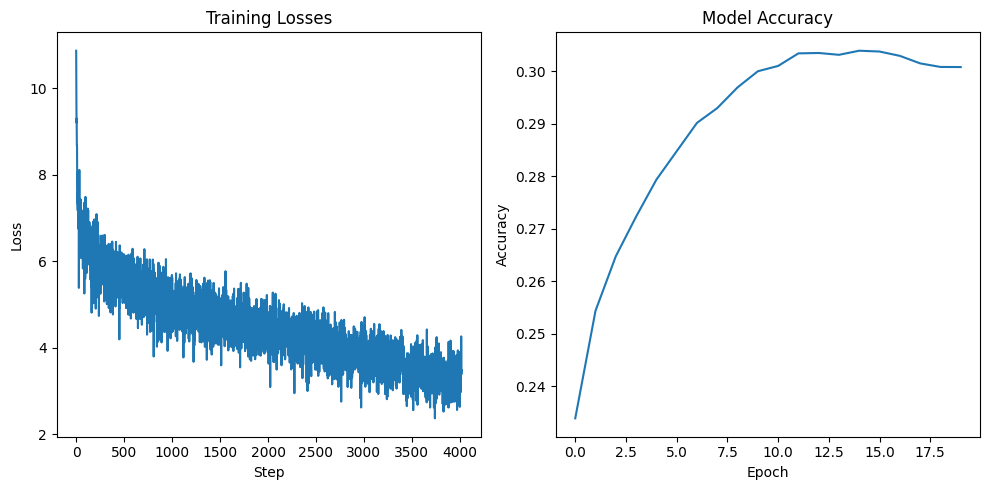

In [33]:
import matplotlib.pyplot as plt

# Plot training losses
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(trainer.train_losses)
plt.title("Training Losses")
plt.xlabel("Step")
plt.ylabel("Loss")

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(trainer.accuracies)
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()


# 4️⃣ Greedy Sampling from a Transformer


[How to generate text: using different decoding methods for language generation with Transformers](https://huggingface.co/blog/how-to-generate).

In [34]:
class TransformerSampler:
    def __init__(self, model: DemoTransformer, tokenizer: GPT2TokenizerFast):
        self.model = model
        self.cfg = model.cfg
        self.tokenizer = tokenizer

    @t.inference_mode()
    def sample(
        self, prompt: str, max_tokens_generated=100, verbose=False, **kwargs
    ) -> str:
        """
        Returns a string of autoregressively generated text, starting from the prompt.

        Sampling terminates at max_tokens_generated, or when the model generates an end-of-sequence token. kwargs are
        passed to sample_next_token, to give detailed instructions on how new tokens are chosen.
        """
        self.model.eval()
        input_ids = self.tokenizer.encode(prompt, return_tensors="pt").to(device)[0]

        for _ in range(max_tokens_generated):
            # Get new logits (make sure we don't pass in more tokens than the model's context length)
            logits = self.model(input_ids[None, -self.cfg.n_ctx :])
            # We only take logits for the last token, because this is what we're sampling
            if hasattr(logits, "logits"):
                logits = logits.logits
            logits = logits[0, -1]
            # Get next token (as a tensor of size (1, 1) so we can concat it to input_ids)
            next_token = t.tensor(
                [TransformerSampler.sample_next_token(input_ids, logits, **kwargs)],
                device=device,
            )
            # Create new input ids string, with shape (1, old_seq_len + 1)
            input_ids = t.cat([input_ids, next_token], dim=-1)
            # Print out results, if required
            if verbose:
                print(self.tokenizer.decode(input_ids), end="\r")
            # If our new token was the end-of-text token, stop
            if next_token == getattr(self.tokenizer, "eos_token_id", None):
                break

        return self.tokenizer.decode(input_ids)

    @staticmethod
    def sample_next_token(
        input_ids: Int[Tensor, "seq_len"],
        logits: Float[Tensor, "d_vocab"],
    ) -> int:
        return TransformerSampler.greedy_search(logits)

    @staticmethod
    def greedy_search(logits: Float[Tensor, "d_vocab"]) -> int:
        """
        Returns the most likely token (as an int).
        """
        return logits.argmax().item()


t.set_grad_enabled(False)  # gradients are not necessary for sampling

model.eval()
sampler = TransformerSampler(model, tokenizer)

prompt = "Jingle bells, jingle bells, jingle all the way"

output = sampler.sample(prompt, max_tokens_generated=8)
print(output)

Jingle bells, jingle bells, jingle all the way of the best of the best of the


In [35]:
reference_gpt2.cfg = model.cfg
sampler = TransformerSampler(reference_gpt2, tokenizer)


prompt = "Jingle bells, jingle bells, jingle all the way"

output = sampler.sample(prompt, max_tokens_generated=8)
print(output)

Jingle bells, jingle bells, jingle all the way up to the top of the mountain.
